In [5]:
import numpy as np
import torch
from torch.autograd import Variable
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import random

In [6]:
#Learns an encoding to distinguish between vectors [1,0] and [0,1]. The representation in
#z-space is visualised below.

num_each_point = 1000
input_size = 2
encoded_size = 1
data = [[1,0] for i in range(num_each_point)]+ [[0,1] for i in range(num_each_point)]
random.shuffle(data)
colours = []
for point in data:
    if point == [1,0]:
        colours.append(0)
    else:
        colours.append(1)

In [7]:
class VAE(nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()
        self.e = nn.Linear(input_size, 10)
        self.e_mean = nn.Linear(10, encoded_size)
        self.e_logvar = nn.Linear(10, encoded_size)
        self.d1 = nn.Linear(encoded_size, 10)
        self.d2 = nn.Linear(10, input_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def en(self, x):
        mean = self.e_mean(self.relu(self.e(x)))
        logvar = self.e_logvar(self.relu(self.e(x)))
        return mean, logvar
    
    def sample(self, mean, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mean + eps*std
    
    def de(self, z):
        output = self.sigmoid(self.d2(self.relu(self.d1(z))))
        return output
    
    def forward(self, x):
        mu, logvar = self.en(x)
        z = self.sample(mu, logvar)
        result = self.de(z)
        return result, mu, logvar

In [11]:
model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [14]:
def lossf(newx, x, mu, logvar):
    BCE = F.binary_cross_entropy(newx, x.view(-1, input_size), reduction = 'sum')
    #KLD = -0.5*torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    #return BCE + KLD
    return BCE

def train(epochs):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for point in data:
            optimizer.zero_grad()
            point = Variable(torch.tensor(point).float())
            newpoint, mu, logvar = model(point)
            loss = lossf(newpoint, point.detach(), mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print('EPOCH: {} LOSS {}'.format(epoch, train_loss))
        print(model.e.weight)

In [15]:
train(5)

C:\Users\Stefan Clarke\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([2])) is deprecated. Please ensure they have the same size.
  


EPOCH: 0 LOSS 77.00150056996063
Parameter containing:
tensor([[ 0.3863,  0.2230],
        [-0.4080, -0.3798],
        [ 0.3873, -0.5550],
        [-0.2748,  0.3101],
        [ 0.3708, -0.5109],
        [ 0.4793,  0.5203],
        [ 0.2111, -0.0333],
        [ 0.1710, -0.5622],
        [ 1.2048, -0.5430],
        [-0.9375,  0.3513]], requires_grad=True)
EPOCH: 1 LOSS 3.9777548520269193
Parameter containing:
tensor([[ 0.4016,  0.2277],
        [-0.4080, -0.3798],
        [ 0.4157, -0.5809],
        [-0.3183,  0.3727],
        [ 0.3708, -0.5109],
        [ 0.4847,  0.5730],
        [ 0.2279, -0.0210],
        [ 0.1710, -0.5622],
        [ 1.2372, -0.5677],
        [-0.9581,  0.3847]], requires_grad=True)
EPOCH: 2 LOSS 0.8955958696353719
Parameter containing:
tensor([[ 0.4136,  0.2287],
        [-0.4080, -0.3798],
        [ 0.4386, -0.6020],
        [-0.3557,  0.4159],
        [ 0.3708, -0.5109],
        [ 0.4875,  0.6079],
        [ 0.2413, -0.0151],
        [ 0.1710, -0.5622],
        [ 

In [90]:
model(torch.tensor([1.0,0.0]))

(tensor([0.9958, 0.0049], grad_fn=<SigmoidBackward>),
 tensor([0.9104], grad_fn=<AddBackward0>),
 tensor([-1.3836], grad_fn=<AddBackward0>))

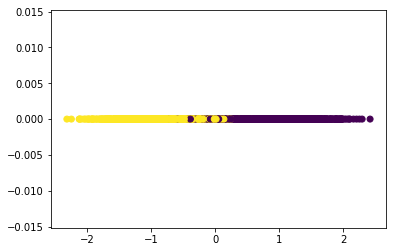

In [102]:
zmean, zlogvar = model.en(torch.tensor(data).float())
zdata = model.sample(zmean, zlogvar)
zdata = zdata.detach().numpy()
zeros = [0 for _ in range(len(zdata))]
plt.scatter(zdata, zeros, c=colours)

([array([  0.,   0.,   0.,   5.,  36., 191., 346., 290., 113.,  19.]),
  array([ 21., 124., 335., 351., 141.,  26.,   2.,   0.,   0.,   0.])],
 array([-2.31629038, -1.84275696, -1.36922355, -0.89569013, -0.42215672,
         0.0513767 ,  0.52491012,  0.99844353,  1.47197695,  1.94551036,
         2.41904378]),
 <a list of 2 Lists of Patches objects>)

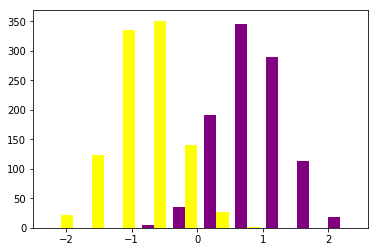

In [146]:
#

zdatayellow = np.array([zdata[i] for i in range(len(zdata)) if colours[i] == 0])
zdatapurple = np.array([zdata[i] for i in range(len(zdata)) if colours[i] == 1])
plt.hist(np.array([zdatayellow, zdatapurple]).T.reshape(len(zdatayellow),2 ), color = ['purple', 'yellow'])